In [ ]:
#!pip install torch
#!pip install transformers

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import requests
import re
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/colab/final_tweet.csv', parse_dates=['datetime'], index_col=0)
#df.drop(['username'], axis=1, inplace = True)

In [18]:
df = pd.read_csv('final_tweet.csv', parse_dates=['datetime'])

In [19]:
df

,datetime,date,cleaned_text
0,2021-01-01 21:00:41+00:00,2021-01-01,new year giveaway win 100 free without no stre...
1,2021-01-01 02:10:53+00:00,2021-01-01,damn right king shill pow is centralized unsca...
2,2021-01-01 18:08:31+00:00,2021-01-01,bitcoin is money everything else is credit
3,2021-01-01 12:20:00+00:00,2021-01-01,yeah im sure you really got rich off of bitcoi...
4,2021-01-01 16:08:22+00:00,2021-01-01,i should definitely take this time to find a s...
...,...,...,...
4367585,2022-06-30 17:39:45+00:00,2022-06-30,cftc brings 17b fraud case involving bitcoin a...
4367586,2022-06-30 09:14:07+00:00,2022-06-30,bitcoin dey my wallet like this
4367587,2022-06-30 17:38:01+00:00,2022-06-30,stop selling your bitcoin to
4367588,2022-06-30 00:47:47+00:00,2022-06-30,the has again denied grayscales spot bitcoin e...


## Data Preparation & Cleaning

In [4]:
def clean_text(text):
    # Remove URL
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove @ mentions
    text = re.sub(r'@[^\s]+', '', text)

    # Remove hashtags except 'bitcoin'
    text = re.sub(r'(?i)#(?!bitcoin|Bitcoin|BITCOIN|BTC|Bitcoin|btc)\w+', '', text)
    text = re.sub(r'(?i)#bitcoin|#Bitcoin|#BITCOIN|#BTC|#Bitcoin|#btc', 'bitcoin', text)

    # Remove repetitions
    text = re.sub('bitcoin bitcoin', 'bitcoin', text)

    # Remove special characters and punctuations
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)

    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()

    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Convert to lowercase
    text = text.lower()

    return text

# Applying clean_text function
df['cleaned_text'] = df['text'].apply(clean_text)

# Dropping the original text column
df.drop(['text'], axis=1, inplace =True)

In [20]:
df

,datetime,date,cleaned_text
0,2021-01-01 21:00:41+00:00,2021-01-01,new year giveaway win 100 free without no stre...
1,2021-01-01 02:10:53+00:00,2021-01-01,damn right king shill pow is centralized unsca...
2,2021-01-01 18:08:31+00:00,2021-01-01,bitcoin is money everything else is credit
3,2021-01-01 12:20:00+00:00,2021-01-01,yeah im sure you really got rich off of bitcoi...
4,2021-01-01 16:08:22+00:00,2021-01-01,i should definitely take this time to find a s...
...,...,...,...
4367585,2022-06-30 17:39:45+00:00,2022-06-30,cftc brings 17b fraud case involving bitcoin a...
4367586,2022-06-30 09:14:07+00:00,2022-06-30,bitcoin dey my wallet like this
4367587,2022-06-30 17:38:01+00:00,2022-06-30,stop selling your bitcoin to
4367588,2022-06-30 00:47:47+00:00,2022-06-30,the has again denied grayscales spot bitcoin e...


## Spliting The Data For Sentiment Labeling and Scoring
The Datafrane is a large file so splitting it into 3 files containing 6 months of data each.

In [21]:
# converting to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# splitting the dataset into 3 parts containg data of 6 months each
df_jan_jun_2021 = df[(df['datetime'] >= '2021-01-01') & (df['datetime'] < '2021-07-01')]
df_jul_dec_2021 = df[(df['datetime'] >= '2021-07-01') & (df['datetime'] < '2022-01-01')]
df_jan_jun_2022 = df[(df['datetime'] >= '2022-01-01') & (df['datetime'] < '2022-07-01')]

# saving in a csv file for further processing
df_jan_jun_2021.to_csv('tweets_jan_jun_2021.csv', index=False)
df_jul_dec_2021.to_csv('tweets_jul_dec_2021.csv', index=False)
df_jan_jun_2022.to_csv('tweets_jan_jun_2022.csv', index=False)

In [ ]:
df_jan_jun_2021 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tweets_jan_jun_2021.csv')
df_jul_dec_2021 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tweets_jul_dec_2021.csv')
df_jan_jun_2022 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tweets_jan_jun_2022.csv')

## Implementing BERT and FinBERT Model for Sentiment Labeling & Scoring
### Jan '21 to Jun '21

In [ ]:
# Using CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Loading pre-trained BERT model and tokenizer
bert_model_name = 'bert-base-uncased'
bert_model = BertForSequenceClassification.from_pretrained(bert_model_name).to(device)
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)

# Loading pre-trained FinBERT model and tokenizer
finbert_model_name = 'ProsusAI/finbert'
finbert_model = BertForSequenceClassification.from_pretrained(finbert_model_name).to(device)
finbert_tokenizer = BertTokenizer.from_pretrained(finbert_model_name)

# Defining custom Dataset
class TweetDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Defining classifying sentiments function
def classify_sentiment(model, tokenizer, batch_texts):
    inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).detach().cpu().numpy()
    return probabilities

# Custom collate function
def collate_fn(batch):
    return batch

# Dataloader for batch processing
batch_size = 64
dataset = TweetDataset(df_jan_jun_2021['cleaned_text'].tolist())
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initializing lists to store sentiment probabilities and labels 
bert_sentiment_probabilities = []
finbert_sentiment_probabilities = []


for batch in tqdm(dataloader, desc="Processing task"):
    batch_texts = [str(text) for text in batch] 
    
    # BERT sentiment classification
    bert_probabilities = classify_sentiment(bert_model, bert_tokenizer, batch_texts)
    bert_sentiment_probabilities.extend(bert_probabilities)
    
    # FinBERT sentiment classification
    finbert_probabilities = classify_sentiment(finbert_model, finbert_tokenizer, batch_texts)
    finbert_sentiment_probabilities.extend(finbert_probabilities)
    
# Converting probabilities to sentiment labels for BERT
bert_sentiment_labels = []
for probabilities in bert_sentiment_probabilities:
    if probabilities[1] > probabilities[0]:
        bert_sentiment_labels.append(1)  # Positive
    else:
        bert_sentiment_labels.append(0)  # Negative

# Converting probabilities to sentiment labels for FinBERT
finbert_sentiment_labels = []
for probabilities in finbert_sentiment_probabilities:
    if probabilities[2] > probabilities[1] and probabilities[2] > probabilities[0]:
        finbert_sentiment_labels.append(2)  # Positive
    elif probabilities[1] > probabilities[2] and probabilities[1] > probabilities[0]:
        finbert_sentiment_labels.append(1)  # Neutral
    else:
        finbert_sentiment_labels.append(0)  # Negative

# labels and probabilities for BERT
df_jan_jun_2021['bert_pos_prob'] = [p[1] for p in bert_sentiment_probabilities]
df_jan_jun_2021['bert_neg_prob'] = [p[0] for p in bert_sentiment_probabilities]
df_jan_jun_2021['bert_label'] = bert_sentiment_labels

# for FinBERT
df_jan_jun_2021['finbert_pos_prob'] = [p[2] for p in finbert_sentiment_probabilities]
df_jan_jun_2021['finbert_neu_prob'] = [p[1] for p in finbert_sentiment_probabilities]
df_jan_jun_2021['finbert_neg_prob'] = [p[0] for p in finbert_sentiment_probabilities]
df_jan_jun_2021['finbert_label'] = finbert_sentiment_labels


df_jan_jun_2021.to_csv('/content/drive/MyDrive/Colab Notebooks/all_senti_jun21.csv', index=False)

print("Task Completed Successfully")


### Jul '21 to Dec '21

In [ ]:
# Using CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Loading pre-trained BERT model and tokenizer
bert_model_name = 'bert-base-uncased'
bert_model = BertForSequenceClassification.from_pretrained(bert_model_name).to(device)
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)

# Load pre-trained FinBERT model and tokenizer
finbert_model_name = 'ProsusAI/finbert'
finbert_model = BertForSequenceClassification.from_pretrained(finbert_model_name).to(device)
finbert_tokenizer = BertTokenizer.from_pretrained(finbert_model_name)


class TweetDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

def classify_sentiment(model, tokenizer, batch_texts):
    inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).detach().cpu().numpy()
    return probabilities


def collate_fn(batch):
    return batch


batch_size = 64
dataset = TweetDataset(df_jul_dec_2021['cleaned_text'].tolist())
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


bert_sentiment_probabilities = []
finbert_sentiment_probabilities = []


for batch in tqdm(dataloader, desc="Processing task"):
    batch_texts = [str(text) for text in batch]  
    

    bert_probabilities = classify_sentiment(bert_model, bert_tokenizer, batch_texts)
    bert_sentiment_probabilities.extend(bert_probabilities)
    

    finbert_probabilities = classify_sentiment(finbert_model, finbert_tokenizer, batch_texts)
    finbert_sentiment_probabilities.extend(finbert_probabilities)
    

bert_sentiment_labels = []
for probabilities in bert_sentiment_probabilities:
    if probabilities[1] > probabilities[0]:
        bert_sentiment_labels.append(1)  # Positive
    else:
        bert_sentiment_labels.append(0)  # Negative


finbert_sentiment_labels = []
for probabilities in finbert_sentiment_probabilities:
    if probabilities[2] > probabilities[1] and probabilities[2] > probabilities[0]:
        finbert_sentiment_labels.append(2)  # Positive
    elif probabilities[1] > probabilities[2] and probabilities[1] > probabilities[0]:
        finbert_sentiment_labels.append(1)  # Neutral
    else:
        finbert_sentiment_labels.append(0)  # Negative


df_jul_dec_2021['bert_pos_prob'] = [p[1] for p in bert_sentiment_probabilities]
df_jul_dec_2021['bert_neg_prob'] = [p[0] for p in bert_sentiment_probabilities]
df_jul_dec_2021['bert_label'] = bert_sentiment_labels


df_jul_dec_2021['finbert_pos_prob'] = [p[2] for p in finbert_sentiment_probabilities]
df_jul_dec_2021['finbert_neu_prob'] = [p[1] for p in finbert_sentiment_probabilities]
df_jul_dec_2021['finbert_neg_prob'] = [p[0] for p in finbert_sentiment_probabilities]
df_jul_dec_2021['finbert_label'] = finbert_sentiment_labels


df_jul_dec_2021.to_csv('/content/drive/MyDrive/Colab Notebooks/all_senti_dec21.csv', index=False)

print("Task Completed Successfully")


### Jan '22 to Jun '22

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

bert_model_name = 'bert-base-uncased'
bert_model = BertForSequenceClassification.from_pretrained(bert_model_name).to(device)
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)


finbert_model_name = 'ProsusAI/finbert'
finbert_model = BertForSequenceClassification.from_pretrained(finbert_model_name).to(device)
finbert_tokenizer = BertTokenizer.from_pretrained(finbert_model_name)


class TweetDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]


def classify_sentiment(model, tokenizer, batch_texts):
    inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).detach().cpu().numpy()
    return probabilities



def collate_fn(batch):
    return batch


batch_size = 64
dataset = TweetDataset(df_jan_jun_2022['cleaned_text'].tolist())
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


bert_sentiment_probabilities = []
finbert_sentiment_probabilities = []


for batch in tqdm(dataloader, desc="Processing task"):
    batch_texts = [str(text) for text in batch]  
    

    bert_probabilities = classify_sentiment(bert_model, bert_tokenizer, batch_texts)
    bert_sentiment_probabilities.extend(bert_probabilities)
    

    finbert_probabilities = classify_sentiment(finbert_model, finbert_tokenizer, batch_texts)
    finbert_sentiment_probabilities.extend(finbert_probabilities)
    

bert_sentiment_labels = []
for probabilities in bert_sentiment_probabilities:
    if probabilities[1] > probabilities[0]:
        bert_sentiment_labels.append(1)  # Positive
    else:
        bert_sentiment_labels.append(0)  # Negative


finbert_sentiment_labels = []
for probabilities in finbert_sentiment_probabilities:
    if probabilities[2] > probabilities[1] and probabilities[2] > probabilities[0]:
        finbert_sentiment_labels.append(2)  # Positive
    elif probabilities[1] > probabilities[2] and probabilities[1] > probabilities[0]:
        finbert_sentiment_labels.append(1)  # Neutral
    else:
        finbert_sentiment_labels.append(0)  # Negative


df_jan_jun_2022['bert_pos_prob'] = [p[1] for p in bert_sentiment_probabilities]
df_jan_jun_2022['bert_neg_prob'] = [p[0] for p in bert_sentiment_probabilities]
df_jan_jun_2022['bert_label'] = bert_sentiment_labels


df_jan_jun_2022['finbert_pos_prob'] = [p[2] for p in finbert_sentiment_probabilities]
df_jan_jun_2022['finbert_neu_prob'] = [p[1] for p in finbert_sentiment_probabilities]
df_jan_jun_2022['finbert_neg_prob'] = [p[0] for p in finbert_sentiment_probabilities]
df_jan_jun_2022['finbert_label'] = finbert_sentiment_labels


df_jan_jun_2022.to_csv('/content/drive/MyDrive/Colab Notebooks/all_senti_jun22.csv', index=False)

print("Task Completed Successfully")


### Merging The Sentiment Labeled Data

In [4]:
df_jan_jun_2021 = pd.read_csv("all_senti_jun21.csv")
df_jul_dec_2021 = pd.read_csv("all_senti_dec21.csv")
df_jan_jun_2022 = pd.read_csv("all_senti_jun22.csv")


In [5]:
# Concatenating the dataframes
combined_df = pd.concat([df_jan_jun_2021, df_jul_dec_2021, df_jan_jun_2022], axis=0)
combined_df.reset_index(drop=True, inplace=True)

In [6]:
# Adding the neu score and neg score as neg score
combined_df['finbert_neg_prob'] = combined_df['finbert_neu_prob'] + combined_df['finbert_neg_prob']
combined_df = combined_df.drop(['cleaned_text','finbert_neu_prob', 'bert_neu_prob', 'date'], axis=1)

In [7]:
combined_df['datetime'] = pd.to_datetime(combined_df['datetime'])
combined_df['datetime'] = combined_df['datetime'].dt.tz_convert(None)


combined_df.set_index('datetime', inplace=True)
aggregated_df = combined_df.resample('H').mean() 
aggregated_df.reset_index(inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9968\2493167483.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aggregated_df = combined_df.resample('H').mean()


In [8]:
aggregated_df

,datetime,bert_pos_prob,bert_neg_prob,bert_label,finbert_pos_prob,finbert_neg_prob,finbert_label
0,2021-01-01 00:00:00,0.455611,0.544389,0.079439,0.774228,0.225772,1.785047
1,2021-01-01 01:00:00,0.449145,0.550855,0.052009,0.765492,0.234508,1.756501
2,2021-01-01 02:00:00,0.457920,0.542080,0.100304,0.797431,0.202569,1.808511
3,2021-01-01 03:00:00,0.452490,0.547510,0.043796,0.785900,0.214100,1.832117
4,2021-01-01 04:00:00,0.452781,0.547219,0.080000,0.769545,0.230455,1.732000
...,...,...,...,...,...,...,...
13099,2022-06-30 19:00:00,0.525346,0.474654,0.760870,0.697109,0.302891,1.732919
13100,2022-06-30 20:00:00,0.526953,0.473047,0.763780,0.707750,0.292250,1.719160
13101,2022-06-30 21:00:00,0.526715,0.473285,0.758808,0.721613,0.278387,1.753388
13102,2022-06-30 22:00:00,0.527127,0.472873,0.825826,0.681636,0.318364,1.732733


In [9]:
# Function to recalculate sentiment label
def recalculate_sentiment(row, label_type):
    if label_type == 'finbert':
        if row['finbert_pos_prob'] > row['finbert_neg_prob']:
            return 'pos'  # Positive
        else:
            return 'neg'  # Negative
    elif label_type == 'bert':
        if row['bert_pos_prob'] > row['bert_neg_prob']:
            return 'pos'  # Positive
        else:
            return 'neg'  # Negative


aggregated_df['finbert_label'] = aggregated_df.apply(recalculate_sentiment, axis=1, args=('finbert',))
aggregated_df['bert_label'] = aggregated_df.apply(recalculate_sentiment, axis=1, args=('bert',))

In [10]:
# Loading the bitcoin dataset
btc= pd.read_csv('hourly_combined_data.csv', index_col=0)
btc.drop(['open', 'high', 'low',  'volume'], axis=1, inplace=True)
btc.rename(columns={'close': 'price',
                   'fng_classification': 'fng_class'}, inplace=True)

In [11]:
btc

,datetime,price,24h_change,7d_change,30d_change,next_1d_movement,next_7d_movement,next_30d_movement,timestamp,fng_value,fng_class,btc_gt
0,2021-01-01 00:00:00,28995.13,-0.43,22.19,52.05,0,-1,-1,2021-01-01,94,Extreme Greed,39
1,2021-01-01 01:00:00,29409.99,2.32,24.50,54.59,0,-1,-1,2021-01-01,94,Extreme Greed,39
2,2021-01-01 02:00:00,29194.65,1.65,23.72,53.35,0,-1,-1,2021-01-01,94,Extreme Greed,39
3,2021-01-01 03:00:00,29278.40,0.88,24.69,54.95,0,-1,-1,2021-01-01,94,Extreme Greed,39
4,2021-01-01 04:00:00,29220.31,0.66,23.75,55.72,0,-1,-1,2021-01-01,94,Extreme Greed,39
...,...,...,...,...,...,...,...,...,...,...,...,...
13134,2022-06-30 19:00:00,18927.34,-6.41,-9.48,-40.15,-1,-1,-1,2022-06-30,11,Extreme Fear,52
13135,2022-06-30 20:00:00,18755.93,-7.26,-9.89,-41.04,-1,-1,-1,2022-06-30,11,Extreme Fear,52
13136,2022-06-30 21:00:00,18819.80,-7.27,-9.03,-40.67,-1,-1,-1,2022-06-30,11,Extreme Fear,52
13137,2022-06-30 22:00:00,18894.54,-6.53,-9.99,-40.71,-1,-1,-1,2022-06-30,11,Extreme Fear,52


In [12]:
btc['datetime'] = pd.to_datetime(btc['datetime'])

# Merging both  dataframes based on date column
aggregated_df = pd.merge(btc, aggregated_df, on='datetime', how='left')
aggregated_df = aggregated_df.drop(['timestamp','datetime'], axis=1)

## Exploratory Data Analysis

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
aggregated_df

,price,24h_change,7d_change,30d_change,next_1d_movement,next_7d_movement,next_30d_movement,fng_value,fng_class,btc_gt,bert_pos_prob,bert_neg_prob,bert_label,finbert_pos_prob,finbert_neg_prob,finbert_label
0,28995.13,-0.43,22.19,52.05,0,-1,-1,94,Extreme Greed,39,0.455611,0.544389,neg,0.774228,0.225772,pos
1,29409.99,2.32,24.50,54.59,0,-1,-1,94,Extreme Greed,39,0.449145,0.550855,neg,0.765492,0.234508,pos
2,29194.65,1.65,23.72,53.35,0,-1,-1,94,Extreme Greed,39,0.457920,0.542080,neg,0.797431,0.202569,pos
3,29278.40,0.88,24.69,54.95,0,-1,-1,94,Extreme Greed,39,0.452490,0.547510,neg,0.785900,0.214100,pos
4,29220.31,0.66,23.75,55.72,0,-1,-1,94,Extreme Greed,39,0.452781,0.547219,neg,0.769545,0.230455,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13134,18927.34,-6.41,-9.48,-40.15,-1,-1,-1,11,Extreme Fear,52,0.525346,0.474654,pos,0.697109,0.302891,pos
13135,18755.93,-7.26,-9.89,-41.04,-1,-1,-1,11,Extreme Fear,52,0.526953,0.473047,pos,0.707750,0.292250,pos
13136,18819.80,-7.27,-9.03,-40.67,-1,-1,-1,11,Extreme Fear,52,0.526715,0.473285,pos,0.721613,0.278387,pos
13137,18894.54,-6.53,-9.99,-40.71,-1,-1,-1,11,Extreme Fear,52,0.527127,0.472873,pos,0.681636,0.318364,pos


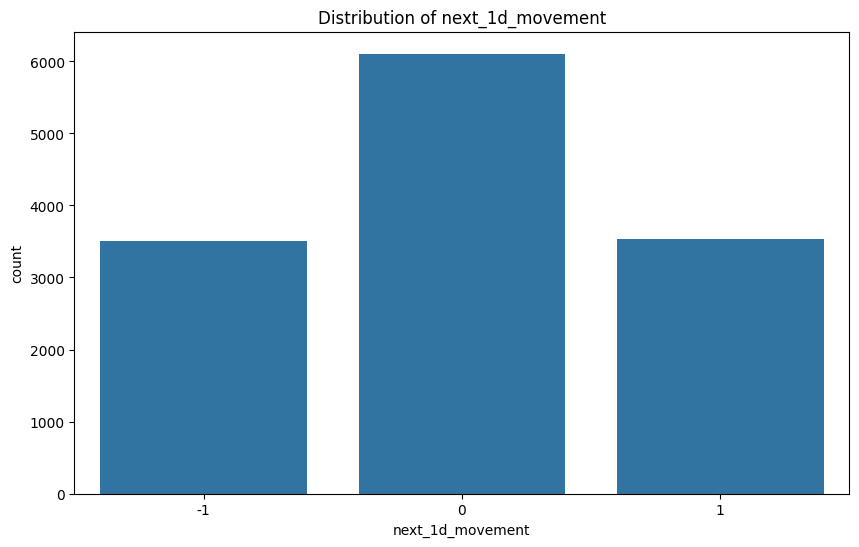

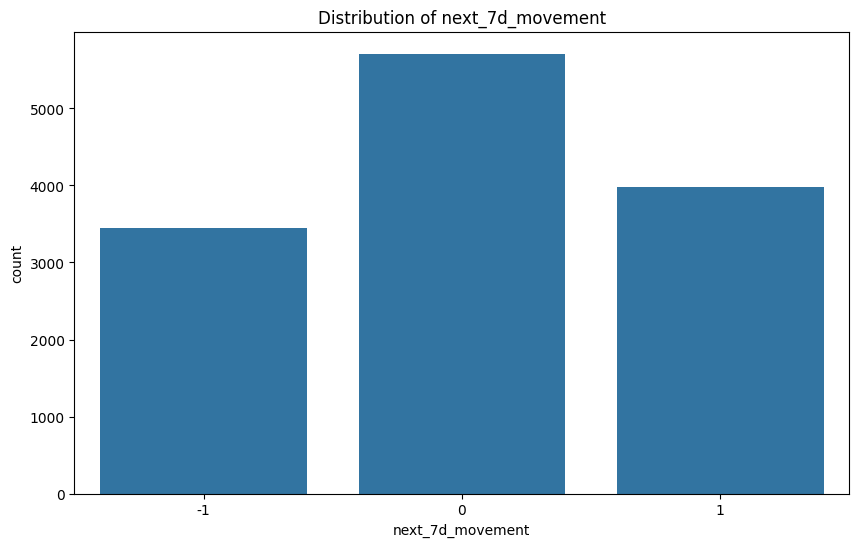

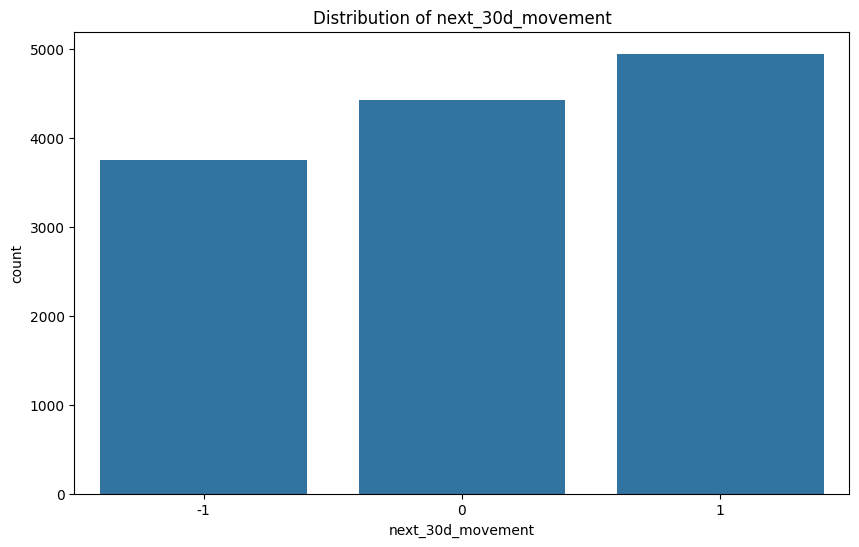

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x='next_1d_movement', data=aggregated_df)
plt.title("Distribution of next_1d_movement")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='next_7d_movement', data=aggregated_df)
plt.title("Distribution of next_7d_movement")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='next_30d_movement', data=aggregated_df)
plt.title("Distribution of next_30d_movement")
plt.show()


## Feature Engineering

### Iterative Imputation

In [16]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from collections import Counter

In [17]:
imputer = IterativeImputer(random_state=30)
numeric_columns = aggregated_df.select_dtypes(include=['number']).columns
aggregated_df[numeric_columns] = imputer.fit_transform(aggregated_df[numeric_columns])

In [18]:
aggregated_df.isnull().sum()

price                0
24h_change           0
7d_change            0
30d_change           0
next_1d_movement     0
next_7d_movement     0
next_30d_movement    0
fng_value            0
fng_class            0
btc_gt               0
bert_pos_prob        0
bert_neg_prob        0
bert_label           0
finbert_pos_prob     0
finbert_neg_prob     0
finbert_label        0
dtype: int64

### One-Hot Encoding

In [19]:
aggregated_df = pd.get_dummies(aggregated_df, columns=['fng_class', 'bert_label', 'finbert_label'])

In [20]:
aggregated_df.dtypes

price                      float64
24h_change                 float64
7d_change                  float64
30d_change                 float64
next_1d_movement           float64
next_7d_movement           float64
next_30d_movement          float64
fng_value                  float64
btc_gt                     float64
bert_pos_prob              float64
bert_neg_prob              float64
finbert_pos_prob           float64
finbert_neg_prob           float64
fng_class_Extreme Fear        bool
fng_class_Extreme Greed       bool
fng_class_Fear                bool
fng_class_Greed               bool
fng_class_Neutral             bool
bert_label_neg                bool
bert_label_pos                bool
finbert_label_neg             bool
finbert_label_pos             bool
dtype: object

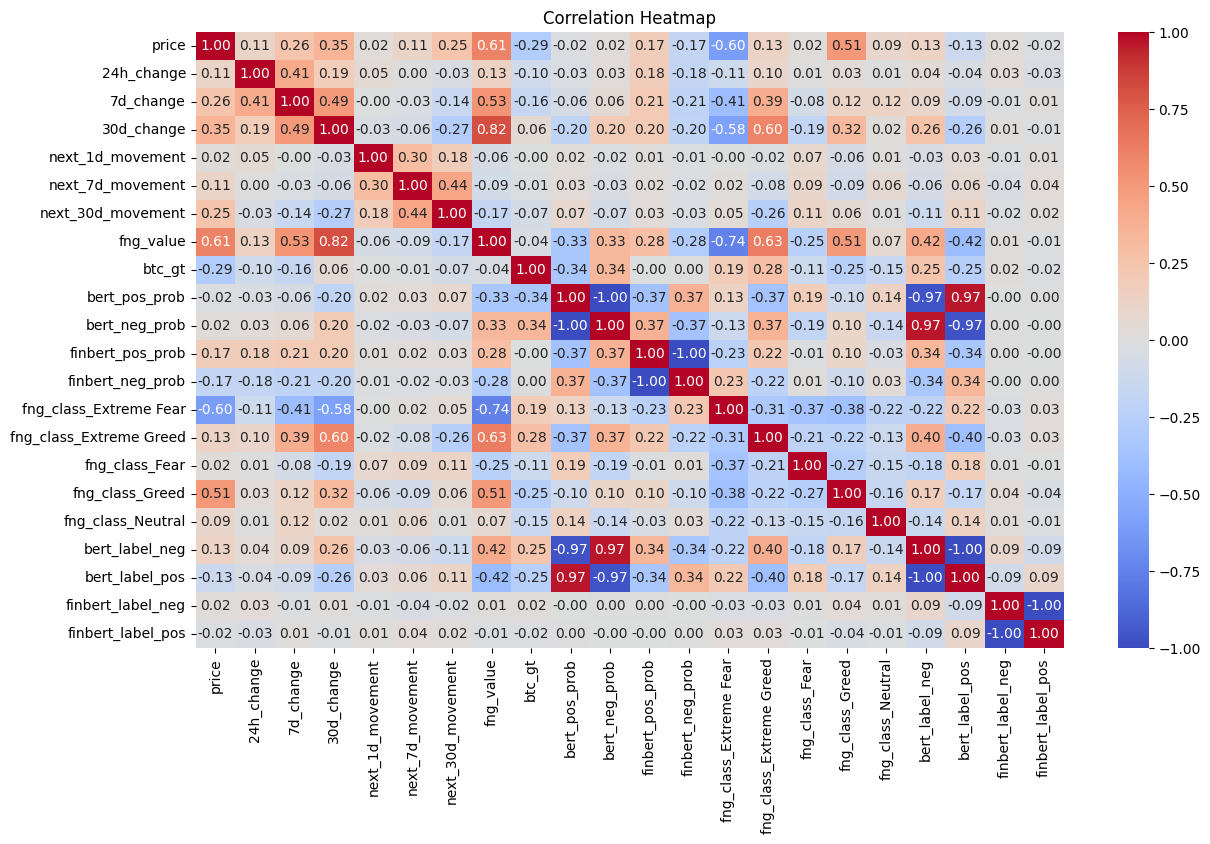

In [21]:
plt.figure(figsize=(14, 8))
sns.heatmap(aggregated_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Train-Test Split

In [22]:
bert_1d = aggregated_df.drop(['finbert_pos_prob','finbert_neg_prob', 'finbert_label_pos','finbert_label_neg', 'next_7d_movement', 'next_30d_movement'], axis=1)
bert_7d = aggregated_df.drop(['finbert_pos_prob','finbert_neg_prob', 'finbert_label_pos','finbert_label_neg', 'next_1d_movement', 'next_30d_movement'], axis=1)
bert_30d = aggregated_df.drop(['finbert_pos_prob','finbert_neg_prob', 'finbert_label_pos','finbert_label_neg', 'next_1d_movement', 'next_7d_movement'], axis=1)

finbert_1d = aggregated_df.drop(['bert_pos_prob','bert_neg_prob', 'bert_label_pos','bert_label_neg', 'next_7d_movement', 'next_30d_movement'], axis=1)
finbert_7d = aggregated_df.drop(['bert_pos_prob','bert_neg_prob', 'bert_label_pos','bert_label_neg', 'next_1d_movement', 'next_30d_movement'], axis=1)
finbert_30d = aggregated_df.drop(['bert_pos_prob','bert_neg_prob', 'bert_label_pos','bert_label_neg', 'next_1d_movement', 'next_7d_movement'], axis=1)

In [23]:
def split_data(df, target):
    x = df.drop(columns=[target])
    y = df[target]
    

    if len(y.shape) == 1 or y.shape[1] == 1:
        y_categorical = to_categorical(y, num_classes=3)  # 3 classes for classification
    else:
        y_categorical = y  
    
    return train_test_split(x, y_categorical, test_size=0.2, stratify=y_categorical, random_state=30)


# Train test splitting for each target variable
x_train_bert_1d, x_test_bert_1d, y_train_bert_1d, y_test_bert_1d = split_data(bert_1d, 'next_1d_movement')
x_train_bert_7d, x_test_bert_7d, y_train_bert_7d, y_test_bert_7d = split_data(bert_7d, 'next_7d_movement')
x_train_bert_30d, x_test_bert_30d, y_train_bert_30d, y_test_bert_30d = split_data(bert_30d, 'next_30d_movement')

x_train_finbert_1d, x_test_finbert_1d, y_train_finbert_1d, y_test_finbert_1d = split_data(finbert_1d, 'next_1d_movement')
x_train_finbert_7d, x_test_finbert_7d, y_train_finbert_7d, y_test_finbert_7d = split_data(finbert_7d, 'next_7d_movement')
x_train_finbert_30d, x_test_finbert_30d, y_train_finbert_30d, y_test_finbert_30d = split_data(finbert_30d, 'next_30d_movement')


### Scaling The Data

In [24]:
def scale_data(x_train, x_test):
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    return x_train_scaled, x_test_scaled

x_train_bert_1d_sc, x_test_bert_1d_sc = scale_data(x_train_bert_1d, x_test_bert_1d)
x_train_bert_7d_sc, x_test_bert_7d_sc = scale_data(x_train_bert_7d, x_test_bert_7d)
x_train_bert_30d_sc, x_test_bert_30d_sc = scale_data(x_train_bert_30d, x_test_bert_30d)

x_train_finbert_1d_sc, x_test_finbert_1d_sc = scale_data(x_train_finbert_1d, x_test_finbert_1d)
x_train_finbert_7d_sc, x_test_finbert_7d_sc = scale_data(x_train_finbert_7d, x_test_finbert_7d)
x_train_finbert_30d_sc, x_test_finbert_30d_sc = scale_data(x_train_finbert_30d, x_test_finbert_30d)

### Data Balancing - SMOTE

In [25]:
def apply_smote(x_train, y_train):
    smote = SMOTE(random_state=42)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
    return x_train_resampled, y_train_resampled

x_train_bert_1d_sm, y_train_bert_1d_sm = apply_smote(x_train_bert_1d_sc, y_train_bert_1d)
x_train_bert_7d_sm, y_train_bert_7d_sm = apply_smote(x_train_bert_7d_sc, y_train_bert_7d)
x_train_bert_30d_sm, y_train_bert_30d_sm = apply_smote(x_train_bert_30d_sc, y_train_bert_30d)

x_train_finbert_1d_sm, y_train_finbert_1d_sm = apply_smote(x_train_finbert_1d_sc, y_train_finbert_1d)
x_train_finbert_7d_sm, y_train_finbert_7d_sm = apply_smote(x_train_finbert_7d_sc, y_train_finbert_7d)
x_train_finbert_30d_sm, y_train_finbert_30d_sm = apply_smote(x_train_finbert_30d_sc, y_train_finbert_30d)

In [26]:
y_train_bert_1d_labels = np.argmax(y_train_bert_1d_sm, axis=1)
y_train_bert_7d_labels = np.argmax(y_train_bert_7d_sm, axis=1)
y_train_bert_30d_labels = np.argmax(y_train_bert_30d_sm, axis=1)

y_train_finbert_1d_labels = np.argmax(y_train_finbert_1d_sm, axis=1)
y_train_finbert_7d_labels = np.argmax(y_train_finbert_7d_sm, axis=1)
y_train_finbert_30d_labels = np.argmax(y_train_finbert_30d_sm, axis=1)


value_counts_bert_1d = Counter(y_train_bert_1d_labels)
value_counts_bert_7d = Counter(y_train_bert_7d_labels)
value_counts_bert_30d = Counter(y_train_bert_30d_labels)

value_counts_finbert_1d = Counter(y_train_finbert_1d_labels)
value_counts_finbert_7d = Counter(y_train_finbert_7d_labels)
value_counts_finbert_30d = Counter(y_train_finbert_30d_labels)

print("Value counts for y_train_bert_1d_sm:")
print(value_counts_bert_1d)

print("Value counts for y_train_bert_7d_sm:")
print(value_counts_bert_7d)

print("Value counts for y_train_bert_30d_sm:")
print(value_counts_bert_30d)

print("Value counts for y_train_finbert_1d_sm:")
print(value_counts_finbert_1d)

print("Value counts for y_train_finbert_7d_sm:")
print(value_counts_finbert_7d)

print("Value counts for y_train_finbert_30d_sm:")
print(value_counts_finbert_30d)

Value counts for y_train_bert_1d_sm:
Counter({2: 4886, 0: 4886, 1: 4886})
Value counts for y_train_bert_7d_sm:
Counter({0: 4570, 2: 4570, 1: 4570})
Value counts for y_train_bert_30d_sm:
Counter({1: 3960, 0: 3960, 2: 3960})
Value counts for y_train_finbert_1d_sm:
Counter({2: 4886, 0: 4886, 1: 4886})
Value counts for y_train_finbert_7d_sm:
Counter({0: 4570, 2: 4570, 1: 4570})
Value counts for y_train_finbert_30d_sm:
Counter({1: 3960, 0: 3960, 2: 3960})


## LSTM Model Training And Testing

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.optimizers import RMSprop
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
def set_random_seeds(seed_value=30):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)

set_random_seeds()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def print_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred)
    print(f'{title} Classification Report:')
    print(report)

def plot_roc_curve(y_true, y_pred, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):  
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    colors = ['blue', 'red', 'green']  
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

### Next Day Price Movement Based on BERT Sentiment Scores and Labels

In [29]:
x_train_bert_1d_sm = x_train_bert_1d_sm.reshape((x_train_bert_1d_sm.shape[0], 1, x_train_bert_1d_sm.shape[1]))
x_test_bert_1d_sc = x_test_bert_1d_sc.reshape((x_test_bert_1d_sc.shape[0], 1, x_test_bert_1d_sc.shape[1]))

# learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# LSTM model with additional layers and regularization
model_brt_1d = Sequential()
model_brt_1d.add(Input(shape=(x_train_bert_1d_sm.shape[1], x_train_bert_1d_sm.shape[2])))
model_brt_1d.add(Bidirectional(LSTM(64, return_sequences=True)))
model_brt_1d.add(Dropout(0.3))
model_brt_1d.add(Bidirectional(LSTM(32)))
model_brt_1d.add(Dropout(0.3))
model_brt_1d.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_brt_1d.add(Dense(3, activation='softmax'))
model_brt_1d.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
mdl_brt_1d = model_brt_1d.fit(x_train_bert_1d_sm, y_train_bert_1d_sm, epochs=50, batch_size=32, 
                              validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluating the model
_, accuracy = model_brt_1d.evaluate(x_test_bert_1d_sc, y_test_bert_1d)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4319 - loss: 1.2435 - val_accuracy: 0.0873 - val_loss: 1.3531 - learning_rate: 0.0010
Epoch 2/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4511 - loss: 1.0549 - val_accuracy: 0.1085 - val_loss: 1.3362 - learning_rate: 0.0010
Epoch 3/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4593 - loss: 1.0437 - val_accuracy: 0.1733 - val_loss: 1.3157 - learning_rate: 0.0010
Epoch 4/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4699 - loss: 1.0350 - val_accuracy: 0.1924 - val_loss: 1.3042 - learning_rate: 0.0010
Epoch 5/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4812 - loss: 1.0268 - val_accuracy: 0.2135 - val_loss: 1.3012 - learning_rate: 0.0010
Epoch 6/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4920 - loss: 1.0198 - val_accuracy: 0.2173 - val_loss: 1.2928 - learning_rate: 0.0010
Epoch 7/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4880 - loss: 1.0148 - 

Epoch 45/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6105 - loss: 0.8415 - val_accuracy: 0.5164 - val_loss: 0.9541 - learning_rate: 2.5000e-04
Epoch 46/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6024 - loss: 0.8411 - val_accuracy: 0.5095 - val_loss: 0.9631 - learning_rate: 2.5000e-04
Epoch 47/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6079 - loss: 0.8355 - val_accuracy: 0.5099 - val_loss: 0.9597 - learning_rate: 2.5000e-04
Epoch 48/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6031 - loss: 0.8424 - val_accuracy: 0.5382 - val_loss: 0.9272 - learning_rate: 1.2500e-04
Epoch 49/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6045 - loss: 0.8393 - val_accuracy: 0.5409 - val_loss: 0.9238 - learning_rate: 1.2500e-04
Epoch 50/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6068 - loss: 0.8394 - val_accuracy: 0.5324 - val_loss: 0.9297 - learning_rate: 1.2500e-04
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5951 

In [75]:
train_loss, train_accuracy = model_brt_1d.evaluate(x_train_bert_1d_sm, y_train_bert_1d_sm)
print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

test_loss, test_accuracy = model_brt_1d.evaluate(x_test_bert_1d_sc, y_test_bert_1d)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

y_train_pred = model_brt_1d.predict(x_train_bert_1d_sm)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true = np.argmax(y_train_bert_1d_sm, axis=1)
print_classification_report(y_train_true, y_train_pred_classes, title='Training')

y_test_pred = model_brt_1d.predict(x_test_bert_1d_sc)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(y_test_bert_1d, axis=1)
print_classification_report(y_test_true, y_test_pred_classes, title='Testing')

459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6381 - loss: 0.8052
Train Loss: 0.8164, Train Accuracy: 0.6281
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5951 - loss: 0.8413
Test Loss: 0.8248, Test Accuracy: 0.6149
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.71      0.60      4886
           1       0.66      0.70      0.68      4886
           2       0.80      0.47      0.59      4886

    accuracy                           0.63     14658
   macro avg       0.66      0.63      0.63     14658
weighted avg       0.66      0.63      0.63     14658

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.69      0.66      1222
           1       0.55      0.66      0.60       706
           2       0.69      0.43      0.53       700

    accuracy              

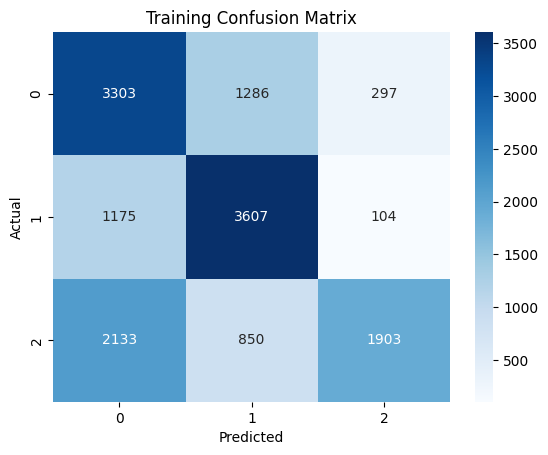

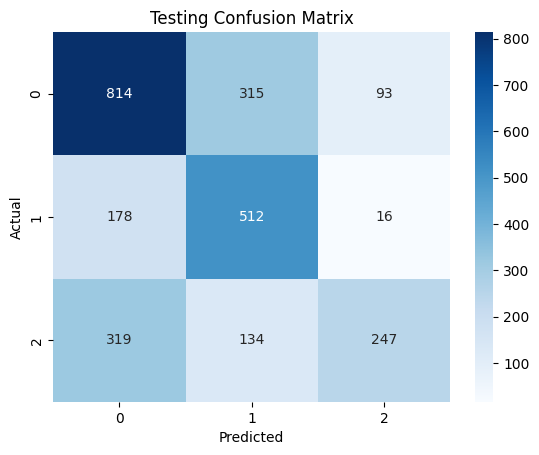

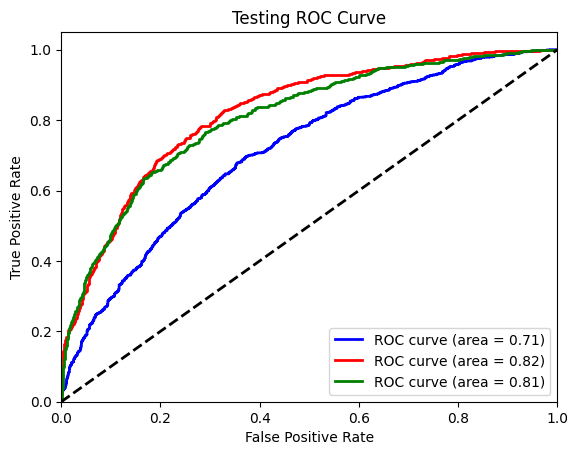

In [81]:
plot_confusion_matrix(y_train_true, y_train_pred_classes, title='Training')
plot_confusion_matrix(y_test_true, y_test_pred_classes, title='Testing')

plot_roc_curve(y_test_bert_1d, y_test_pred, title='Testing')


### Next Day Price Movement Based on FinBERT Sentiment Scores and Labels

In [32]:
x_train_finbert_1d_sm = x_train_finbert_1d_sm.reshape((x_train_finbert_1d_sm.shape[0], 1, x_train_finbert_1d_sm.shape[1]))
x_test_finbert_1d_sc = x_test_finbert_1d_sc.reshape((x_test_finbert_1d_sc.shape[0], 1, x_test_finbert_1d_sc.shape[1]))


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


model_fnbrt_1d = Sequential()
model_fnbrt_1d.add(Input(shape=(x_train_finbert_1d_sm.shape[1], x_train_finbert_1d_sm.shape[2])))
model_fnbrt_1d.add(Bidirectional(LSTM(64, return_sequences=True)))
model_fnbrt_1d.add(Dropout(0.3))
model_fnbrt_1d.add(Bidirectional(LSTM(32)))
model_fnbrt_1d.add(Dropout(0.3))
model_fnbrt_1d.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_fnbrt_1d.add(Dense(3, activation='softmax'))
model_fnbrt_1d.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


mdl_fnbrt_1d = model_fnbrt_1d.fit(x_train_finbert_1d_sm, y_train_finbert_1d_sm, epochs=50, batch_size=32, 
                              validation_split=0.2, callbacks=[early_stopping, reduce_lr])


_, accuracy = model_fnbrt_1d.evaluate(x_test_finbert_1d_sc, y_test_finbert_1d)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4142 - loss: 1.2515 - val_accuracy: 0.0443 - val_loss: 1.3604 - learning_rate: 0.0010
Epoch 2/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4321 - loss: 1.0627 - val_accuracy: 0.0672 - val_loss: 1.3473 - learning_rate: 0.0010
Epoch 3/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4393 - loss: 1.0551 - val_accuracy: 0.0935 - val_loss: 1.3460 - learning_rate: 0.0010
Epoch 4/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4451 - loss: 1.0499 - val_accuracy: 0.1306 - val_loss: 1.3330 - learning_rate: 0.0010
Epoch 5/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4604 - loss: 1.0438 - val_accuracy: 0.1579 - val_loss: 1.3233 - learning_rate: 0.0010
Epoch 6/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4656 - loss: 1.0376 - val_accuracy: 0.1630 - val_loss: 1.3205 - learning_rate: 0.0010
Epoch 7/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4731 - loss: 1.0330 - 

Epoch 45/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5906 - loss: 0.8822 - val_accuracy: 0.4451 - val_loss: 1.0718 - learning_rate: 0.0010
Epoch 46/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.8750 - val_accuracy: 0.4560 - val_loss: 1.0563 - learning_rate: 0.0010
Epoch 47/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.8736 - val_accuracy: 0.4717 - val_loss: 1.0531 - learning_rate: 0.0010
Epoch 48/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5887 - loss: 0.8791 - val_accuracy: 0.4956 - val_loss: 1.0089 - learning_rate: 0.0010
Epoch 49/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6024 - loss: 0.8707 - val_accuracy: 0.4915 - val_loss: 1.0182 - learning_rate: 0.0010
Epoch 50/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6079 - loss: 0.8591 - val_accuracy: 0.4778 - val_loss: 1.0326 - learning_rate: 0.0010
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5891 - loss: 0.8815
Test Accu

In [78]:
# Evaluate and print training and testing performance
train_loss, train_accuracy = model_fnbrt_1d.evaluate(x_train_finbert_1d_sm, y_train_finbert_1d_sm)
print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

test_loss, test_accuracy = model_fnbrt_1d.evaluate(x_test_finbert_1d_sc, y_test_finbert_1d)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Classification reports (tabular format)
y_train_pred = model_fnbrt_1d.predict(x_train_finbert_1d_sm)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true = np.argmax(y_train_finbert_1d_sm, axis=1)
print_classification_report(y_train_true, y_train_pred_classes, title='Training')

y_test_pred = model_fnbrt_1d.predict(x_test_finbert_1d_sc)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(y_test_finbert_1d, axis=1)
print_classification_report(y_test_true, y_test_pred_classes, title='Testing')


459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6134 - loss: 0.8461
Train Loss: 0.8599, Train Accuracy: 0.6012
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5891 - loss: 0.8815
Test Loss: 0.8747, Test Accuracy: 0.5986
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.68      0.57      4886
           1       0.63      0.74      0.68      4886
           2       0.83      0.39      0.53      4886

    accuracy                           0.60     14658
   macro avg       0.65      0.60      0.59     14658
weighted avg       0.65      0.60      0.59     14658

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.67      0.64      1222
           1       0.53      0.73      0.61       706
           2       0.69      0.35      0.47       700

    accuracy              

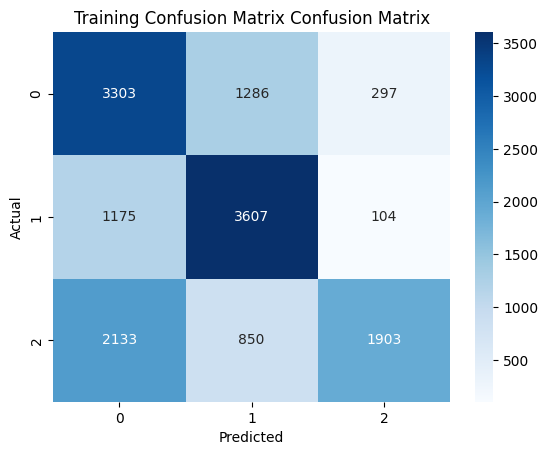

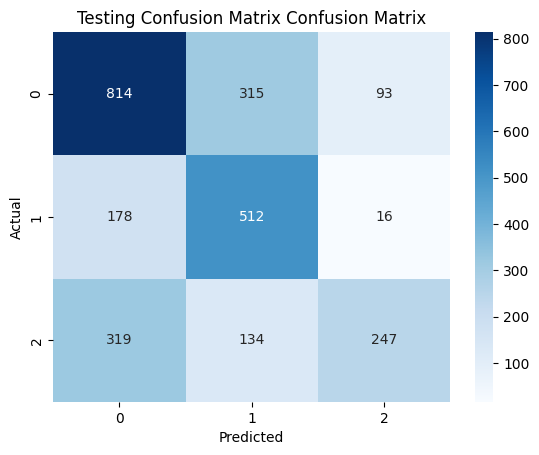

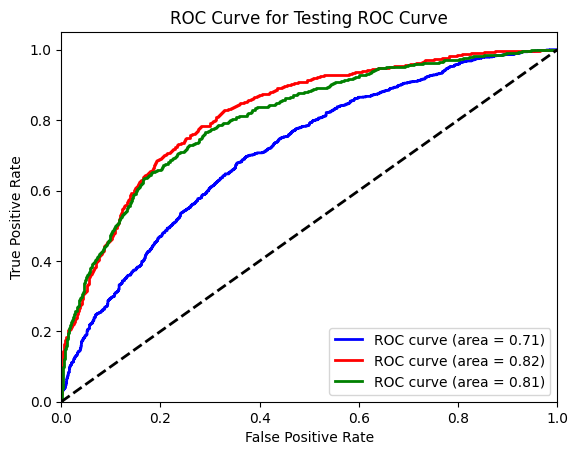

In [82]:
# Confusion matrices as heatmap
plot_confusion_matrix(y_train_true, y_train_pred_classes, title='Training')
plot_confusion_matrix(y_test_true, y_test_pred_classes, title='Testing')

# ROC curve
plot_roc_curve(y_test_finbert_1d, y_test_pred, title=' Testing')

### Next Week Price Movement Based on BERT Sentiment Scores and Labels

In [35]:
x_train_bert_7d_sm = x_train_bert_7d_sm.reshape((x_train_bert_7d_sm.shape[0], 1, x_train_bert_7d_sm.shape[1]))
x_test_bert_7d_sc = x_test_bert_7d_sc.reshape((x_test_bert_7d_sc.shape[0], 1, x_test_bert_7d_sc.shape[1]))


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


model_brt_7d = Sequential()
model_brt_7d.add(Input(shape=(x_train_bert_7d_sm.shape[1], x_train_bert_7d_sm.shape[2])))
model_brt_7d.add(Bidirectional(LSTM(64, return_sequences=True)))
model_brt_7d.add(Dropout(0.3))
model_brt_7d.add(Bidirectional(LSTM(32)))
model_brt_7d.add(Dropout(0.3))
model_brt_7d.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_brt_7d.add(Dense(3, activation='softmax'))
model_brt_7d.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

mdl_brt_7d = model_brt_7d.fit(x_train_bert_7d_sm, y_train_bert_7d_sm, epochs=50, batch_size=32, 
                              validation_split=0.2, callbacks=[early_stopping, reduce_lr])


_, accuracy = model_brt_7d.evaluate(x_test_bert_7d_sc, y_test_bert_7d)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4430 - loss: 1.2550 - val_accuracy: 0.3093 - val_loss: 1.2484 - learning_rate: 0.0010
Epoch 2/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5041 - loss: 1.0213 - val_accuracy: 0.3585 - val_loss: 1.1479 - learning_rate: 0.0010
Epoch 3/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5283 - loss: 0.9707 - val_accuracy: 0.4395 - val_loss: 1.0721 - learning_rate: 0.0010
Epoch 4/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5541 - loss: 0.9395 - val_accuracy: 0.4668 - val_loss: 1.0430 - learning_rate: 0.0010
Epoch 5/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5778 - loss: 0.9086 - val_accuracy: 0.4996 - val_loss: 0.9918 - learning_rate: 0.0010
Epoch 6/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5798 - loss: 0.8887 - val_accuracy: 0.5026 - val_loss: 0.9627 - learning_rate: 0.0010
Epoch 7/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6005 - loss: 0.8608 - 

Epoch 45/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8269 - loss: 0.4436 - val_accuracy: 0.8735 - val_loss: 0.3404 - learning_rate: 0.0010
Epoch 46/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8263 - loss: 0.4457 - val_accuracy: 0.8574 - val_loss: 0.3602 - learning_rate: 0.0010
Epoch 47/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8221 - loss: 0.4429 - val_accuracy: 0.8731 - val_loss: 0.3250 - learning_rate: 0.0010
Epoch 48/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8290 - loss: 0.4368 - val_accuracy: 0.8869 - val_loss: 0.3177 - learning_rate: 0.0010
Epoch 49/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8251 - loss: 0.4373 - val_accuracy: 0.8818 - val_loss: 0.3311 - learning_rate: 0.0010
Epoch 50/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8289 - loss: 0.4308 - val_accuracy: 0.8826 - val_loss: 0.3208 - learning_rate: 0.0010
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8547 - loss: 0.3700
Test Accu

In [83]:
# Evaluate and print training and testing performance
train_loss, train_accuracy = model_brt_7d.evaluate(x_train_bert_7d_sm, y_train_bert_7d_sm)
print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

test_loss, test_accuracy = model_brt_7d.evaluate(x_test_bert_7d_sc, y_test_bert_7d)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Classification reports (tabular format)
y_train_pred = model_brt_7d.predict(x_train_bert_7d_sm)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true = np.argmax(y_train_bert_7d_sm, axis=1)
print_classification_report(y_train_true, y_train_pred_classes, title='Training')

y_test_pred = model_brt_7d.predict(x_test_bert_7d_sc)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(y_test_bert_7d, axis=1)
print_classification_report(y_test_true, y_test_pred_classes, title='Testing')


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8776 - loss: 0.3277
Train Loss: 0.3278, Train Accuracy: 0.8788
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8547 - loss: 0.3700
Test Loss: 0.3753, Test Accuracy: 0.8535
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      4570
           1       0.90      0.89      0.90      4570
           2       0.94      0.87      0.91      4570

    accuracy                           0.88     13710
   macro avg       0.88      0.88      0.88     13710
weighted avg       0.88      0.88      0.88     13710

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1142
           1       0.86      0.88      0.87       796
           2       0.88      0.84      0.86       690

    accuracy              

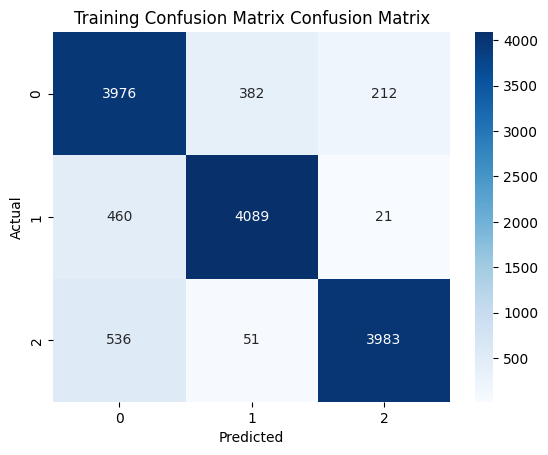

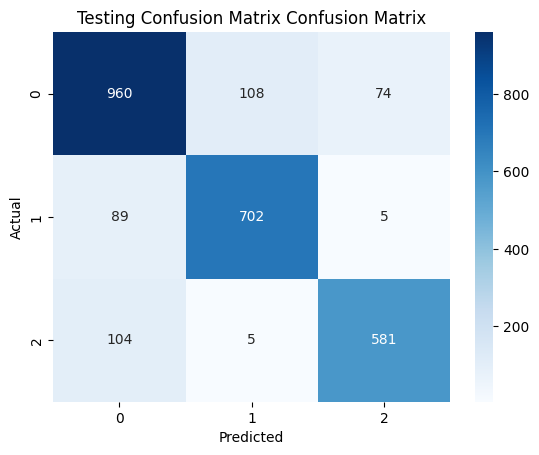

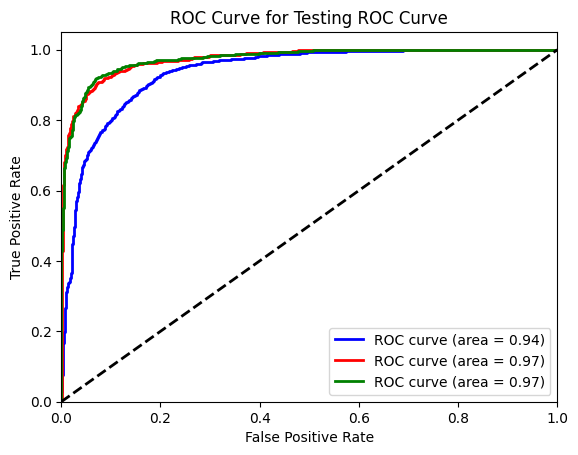

In [84]:
# Confusion matrices as heatmap
plot_confusion_matrix(y_train_true, y_train_pred_classes, title='Training Confusion Matrix')
plot_confusion_matrix(y_test_true, y_test_pred_classes, title='Testing Confusion Matrix')

# ROC curve
plot_roc_curve(y_test_bert_7d, y_test_pred, title='ROC Curve for Testing')


### Next Week Price Movement Based on FinBERT Sentiment Scores and Labels

In [38]:
x_train_finbert_7d_sm = x_train_finbert_7d_sm.reshape((x_train_finbert_7d_sm.shape[0], 1, x_train_finbert_7d_sm.shape[1]))
x_test_finbert_7d_sc = x_test_finbert_7d_sc.reshape((x_test_finbert_7d_sc.shape[0], 1, x_test_finbert_7d_sc.shape[1]))


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


model_fnbrt_7d = Sequential()
model_fnbrt_7d.add(Input(shape=(x_train_finbert_7d_sm.shape[1], x_train_finbert_7d_sm.shape[2])))
model_fnbrt_7d.add(Bidirectional(LSTM(64, return_sequences=True)))
model_fnbrt_7d.add(Dropout(0.3))
model_fnbrt_7d.add(Bidirectional(LSTM(32)))
model_fnbrt_7d.add(Dropout(0.3))
model_fnbrt_7d.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_fnbrt_7d.add(Dense(3, activation='softmax'))
model_fnbrt_7d.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


mdl_fnbrt_7d = model_fnbrt_7d.fit(x_train_finbert_7d_sm, y_train_finbert_7d_sm, epochs=50, batch_size=32, 
                              validation_split=0.2, callbacks=[early_stopping, reduce_lr])


_, accuracy = model_fnbrt_7d.evaluate(x_test_finbert_7d_sc, y_test_finbert_7d)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4399 - loss: 1.2503 - val_accuracy: 0.2688 - val_loss: 1.2433 - learning_rate: 0.0010
Epoch 2/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4954 - loss: 1.0230 - val_accuracy: 0.3370 - val_loss: 1.1672 - learning_rate: 0.0010
Epoch 3/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5241 - loss: 0.9871 - val_accuracy: 0.3753 - val_loss: 1.1265 - learning_rate: 0.0010
Epoch 4/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5387 - loss: 0.9585 - val_accuracy: 0.4183 - val_loss: 1.0745 - learning_rate: 0.0010
Epoch 5/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5443 - loss: 0.9362 - val_accuracy: 0.4431 - val_loss: 1.0534 - learning_rate: 0.0010
Epoch 6/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5556 - loss: 0.9220 - val_accuracy: 0.4621 - val_loss: 1.0221 - learning_rate: 0.0010
Epoch 7/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5652 - loss: 0.9020 - 

Epoch 45/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8029 - loss: 0.4989 - val_accuracy: 0.8727 - val_loss: 0.3567 - learning_rate: 0.0010
Epoch 46/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8075 - loss: 0.4996 - val_accuracy: 0.8705 - val_loss: 0.3580 - learning_rate: 0.0010
Epoch 47/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8139 - loss: 0.4830 - val_accuracy: 0.8804 - val_loss: 0.3365 - learning_rate: 0.0010
Epoch 48/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8082 - loss: 0.4917 - val_accuracy: 0.8815 - val_loss: 0.3375 - learning_rate: 0.0010
Epoch 49/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8123 - loss: 0.4827 - val_accuracy: 0.8833 - val_loss: 0.3354 - learning_rate: 0.0010
Epoch 50/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8213 - loss: 0.4763 - val_accuracy: 0.8866 - val_loss: 0.3330 - learning_rate: 0.0010
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8633 - loss: 0.3718
Test Accu

In [85]:
# Evaluate and print training and testing performance
train_loss, train_accuracy = model_fnbrt_7d.evaluate(x_train_finbert_7d_sm, y_train_finbert_7d_sm)
print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

test_loss, test_accuracy = model_fnbrt_7d.evaluate(x_test_finbert_7d_sc, y_test_finbert_7d)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Classification reports (tabular format)
y_train_pred = model_fnbrt_7d.predict(x_train_finbert_7d_sm)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true = np.argmax(y_train_finbert_7d_sm, axis=1)
print_classification_report(y_train_true, y_train_pred_classes, title='Training')

y_test_pred = model_fnbrt_7d.predict(x_test_finbert_7d_sc)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(y_test_finbert_7d, axis=1)
print_classification_report(y_test_true, y_test_pred_classes, title='Testing')


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8752 - loss: 0.3499
Train Loss: 0.3490, Train Accuracy: 0.8755
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8633 - loss: 0.3718
Test Loss: 0.3845, Test Accuracy: 0.8565
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      4570
           1       0.91      0.89      0.90      4570
           2       0.94      0.86      0.90      4570

    accuracy                           0.88     13710
   macro avg       0.88      0.88      0.88     13710
weighted avg       0.88      0.88      0.88     13710

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1142
           1       0.88      0.88      0.88       796
           2       0.87      0.83      0.85       690

    accuracy              

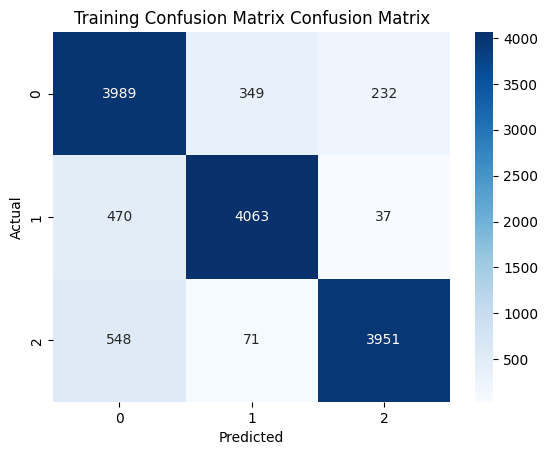

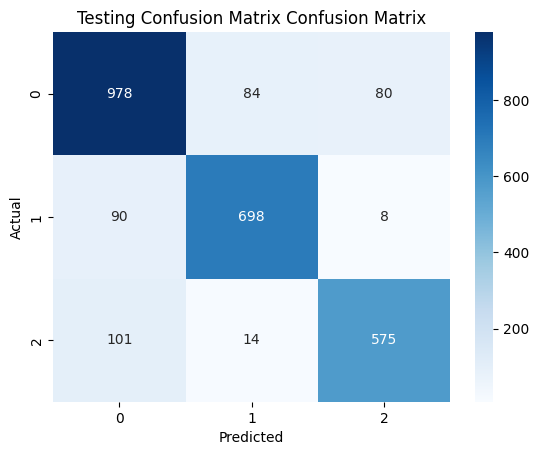

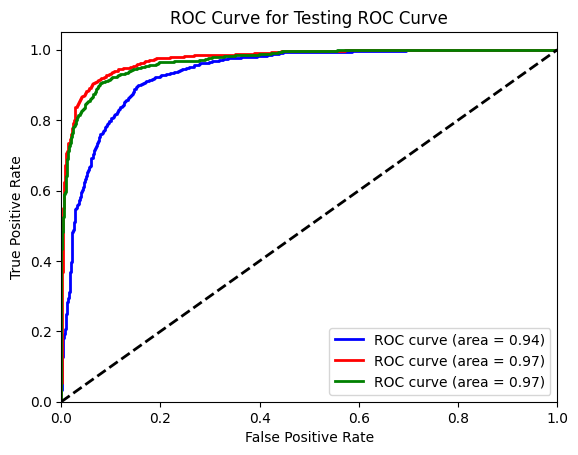

In [86]:
# Confusion matrices as heatmap
plot_confusion_matrix(y_train_true, y_train_pred_classes, title='Training Confusion Matrix')
plot_confusion_matrix(y_test_true, y_test_pred_classes, title='Testing Confusion Matrix')

# ROC curve
plot_roc_curve(y_test_finbert_7d, y_test_pred, title='ROC Curve for Testing')

### Next Month Price Movement Based on BERT Sentiment Scores and Labels

In [41]:
x_train_bert_30d_sm = x_train_bert_30d_sm.reshape((x_train_bert_30d_sm.shape[0], 1, x_train_bert_30d_sm.shape[1]))
x_test_bert_30d_sc = x_test_bert_30d_sc.reshape((x_test_bert_30d_sc.shape[0], 1, x_test_bert_30d_sc.shape[1]))


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


model_brt_30d = Sequential()
model_brt_30d.add(Input(shape=(x_train_bert_30d_sm.shape[1], x_train_bert_30d_sm.shape[2])))
model_brt_30d.add(Bidirectional(LSTM(64, return_sequences=True)))
model_brt_30d.add(Dropout(0.3))
model_brt_30d.add(Bidirectional(LSTM(32)))
model_brt_30d.add(Dropout(0.3))
model_brt_30d.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_brt_30d.add(Dense(3, activation='softmax'))
model_brt_30d.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


mdl_brt_30d = model_brt_30d.fit(x_train_bert_30d_sm, y_train_bert_30d_sm, epochs=50, batch_size=32, 
                              validation_split=0.2, callbacks=[early_stopping, reduce_lr])


_, accuracy = model_brt_30d.evaluate(x_test_bert_30d_sc, y_test_bert_30d)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4671 - loss: 1.2283 - val_accuracy: 0.6734 - val_loss: 0.8022 - learning_rate: 0.0010
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7073 - loss: 0.7400 - val_accuracy: 0.7593 - val_loss: 0.6169 - learning_rate: 0.0010
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7585 - loss: 0.6161 - val_accuracy: 0.7929 - val_loss: 0.5508 - learning_rate: 0.0010
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7810 - loss: 0.5647 - val_accuracy: 0.8047 - val_loss: 0.5057 - learning_rate: 0.0010
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7967 - loss: 0.5216 - val_accuracy: 0.8102 - val_loss: 0.4655 - learning_rate: 0.0010
Epoch 6/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8054 - loss: 0.4964 - val_accuracy: 0.8249 - val_loss: 0.4410 - learning_rate: 0.0010
Epoch 7/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8180 - loss: 0.4744 - 

Epoch 45/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9210 - loss: 0.2188 - val_accuracy: 0.9495 - val_loss: 0.1680 - learning_rate: 0.0010
Epoch 46/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9229 - loss: 0.2228 - val_accuracy: 0.9465 - val_loss: 0.1621 - learning_rate: 0.0010
Epoch 47/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9229 - loss: 0.2113 - val_accuracy: 0.9487 - val_loss: 0.1571 - learning_rate: 0.0010
Epoch 48/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9247 - loss: 0.2131 - val_accuracy: 0.9453 - val_loss: 0.1600 - learning_rate: 0.0010
Epoch 49/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9264 - loss: 0.2109 - val_accuracy: 0.9457 - val_loss: 0.1595 - learning_rate: 0.0010
Epoch 50/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9255 - loss: 0.2066 - val_accuracy: 0.9457 - val_loss: 0.1645 - learning_rate: 0.0010
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9454 - loss: 0.1602
Test Accu

In [87]:
# Evaluate and print training and testing performance
train_loss, train_accuracy = model_brt_30d.evaluate(x_train_bert_30d_sm, y_train_bert_30d_sm)
print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

test_loss, test_accuracy = model_brt_30d.evaluate(x_test_bert_30d_sc, y_test_bert_30d)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Classification reports (tabular format)
y_train_pred = model_brt_30d.predict(x_train_bert_30d_sm)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true = np.argmax(y_train_bert_30d_sm, axis=1)
print_classification_report(y_train_true, y_train_pred_classes, title='Training')

y_test_pred = model_brt_30d.predict(x_test_bert_30d_sc)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(y_test_bert_30d, axis=1)
print_classification_report(y_test_true, y_test_pred_classes, title='Testing')


372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9470 - loss: 0.1613
Train Loss: 0.1587, Train Accuracy: 0.9477
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9454 - loss: 0.1602
Test Loss: 0.1689, Test Accuracy: 0.9425
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3960
           1       0.95      0.96      0.96      3960
           2       0.97      0.96      0.96      3960

    accuracy                           0.95     11880
   macro avg       0.95      0.95      0.95     11880
weighted avg       0.95      0.95      0.95     11880

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       887
           1       0.96      0.95      0.96       990
           2       0.96      0.95      0.95       751

    accuracy              

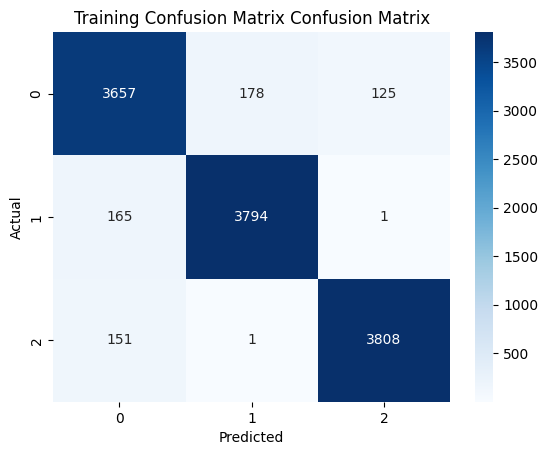

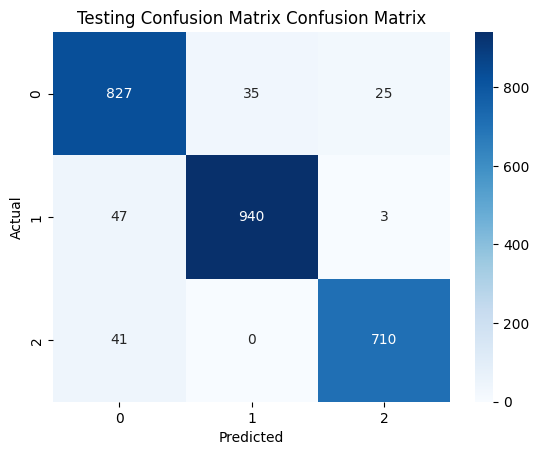

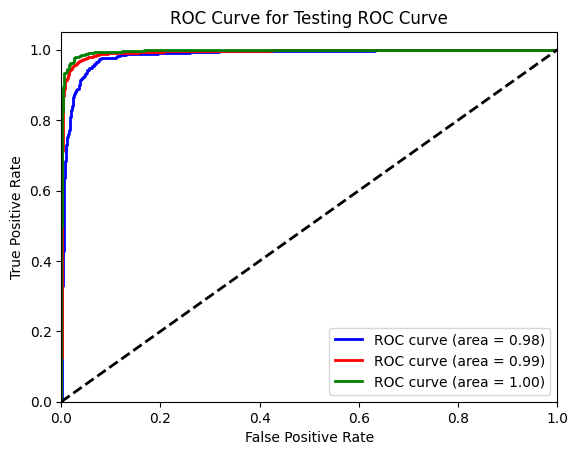

In [88]:
# Confusion matrices as heatmap
plot_confusion_matrix(y_train_true, y_train_pred_classes, title='Training Confusion Matrix')
plot_confusion_matrix(y_test_true, y_test_pred_classes, title='Testing Confusion Matrix')

# ROC curve
plot_roc_curve(y_test_bert_30d, y_test_pred, title='ROC Curve for Testing')

### Next Month Price Movement Based on FinBERT Sentiment Scores and Labels

In [44]:
x_train_finbert_30d_sm = x_train_finbert_30d_sm.reshape((x_train_finbert_30d_sm.shape[0], 1, x_train_finbert_30d_sm.shape[1]))
x_test_finbert_30d_sc = x_test_finbert_30d_sc.reshape((x_test_finbert_30d_sc.shape[0], 1, x_test_finbert_30d_sc.shape[1]))


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


model_fnbrt_30d = Sequential()
model_fnbrt_30d.add(Input(shape=(x_train_finbert_30d_sm.shape[1], x_train_finbert_30d_sm.shape[2])))
model_fnbrt_30d.add(Bidirectional(LSTM(64, return_sequences=True)))
model_fnbrt_30d.add(Dropout(0.3))
model_fnbrt_30d.add(Bidirectional(LSTM(32)))
model_fnbrt_30d.add(Dropout(0.3))
model_fnbrt_30d.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_fnbrt_30d.add(Dense(3, activation='softmax'))
model_fnbrt_30d.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


mdl_fnbrt_30d = model_fnbrt_30d.fit(x_train_finbert_30d_sm, y_train_finbert_30d_sm, epochs=50, batch_size=32, 
                              validation_split=0.2, callbacks=[early_stopping, reduce_lr])


_, accuracy = model_fnbrt_30d.evaluate(x_test_finbert_30d_sc, y_test_finbert_30d)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4923 - loss: 1.2207 - val_accuracy: 0.6069 - val_loss: 0.8848 - learning_rate: 0.0010
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6463 - loss: 0.8248 - val_accuracy: 0.6978 - val_loss: 0.7387 - learning_rate: 0.0010
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7033 - loss: 0.7207 - val_accuracy: 0.7399 - val_loss: 0.6593 - learning_rate: 0.0010
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7329 - loss: 0.6663 - val_accuracy: 0.7647 - val_loss: 0.5933 - learning_rate: 0.0010
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7487 - loss: 0.6241 - val_accuracy: 0.7803 - val_loss: 0.5553 - learning_rate: 0.0010
Epoch 6/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7631 - loss: 0.5941 - val_accuracy: 0.7963 - val_loss: 0.5299 - learning_rate: 0.0010
Epoch 7/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7738 - loss: 0.5714 - 

Epoch 45/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9085 - loss: 0.2523 - val_accuracy: 0.9364 - val_loss: 0.1886 - learning_rate: 0.0010
Epoch 46/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9086 - loss: 0.2510 - val_accuracy: 0.9386 - val_loss: 0.1783 - learning_rate: 0.0010
Epoch 47/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9073 - loss: 0.2509 - val_accuracy: 0.9419 - val_loss: 0.1805 - learning_rate: 0.0010
Epoch 48/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9086 - loss: 0.2441 - val_accuracy: 0.9419 - val_loss: 0.1732 - learning_rate: 5.0000e-04
Epoch 49/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9156 - loss: 0.2345 - val_accuracy: 0.9457 - val_loss: 0.1652 - learning_rate: 5.0000e-04
Epoch 50/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9127 - loss: 0.2420 - val_accuracy: 0.9487 - val_loss: 0.1637 - learning_rate: 5.0000e-04
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9373 - loss: 0.18

In [45]:
# Evaluate and print training and testing performance
train_loss, train_accuracy = model_fnbrt_30d.evaluate(x_train_finbert_30d_sm, y_train_finbert_30d_sm)
print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

test_loss, test_accuracy = model_fnbrt_30d.evaluate(x_test_finbert_30d_sc, y_test_finbert_30d)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Classification reports (tabular format)
y_train_pred = model_fnbrt_30d.predict(x_train_finbert_30d_sm)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true = np.argmax(y_train_finbert_30d_sm, axis=1)
print_classification_report(y_train_true, y_train_pred_classes, title='Training')

y_test_pred = model_fnbrt_30d.predict(x_test_finbert_30d_sc)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(y_test_finbert_30d, axis=1)
print_classification_report(y_test_true, y_test_pred_classes, title='Testing')

# Confusion matrices as heatmap
plot_confusion_matrix(y_train_true, y_train_pred_classes, title='Training Confusion Matrix')
plot_confusion_matrix(y_test_true, y_test_pred_classes, title='Testing Confusion Matrix')

# ROC curve
plot_roc_curve(y_test_finbert_30d, y_test_pred, title='ROC Curve for Testing')


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       887
           1       0.96      0.94      0.95       990
           2       0.96      0.94      0.95       751

    accuracy                           0.93      2628
   macro avg       0.94      0.93      0.93      2628
weighted avg       0.93      0.93      0.93      2628



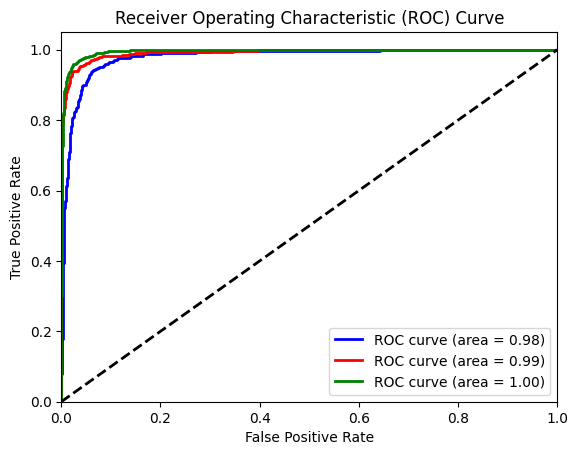